In [1]:
# Import packages

import numpy as np
import random
import matplotlib.pyplot as plt
from array2gif import write_gif
from tqdm import tqdm

In [123]:
# Create initial lattice to start

def create_random_lattice(rows, cols, prob = .5):

    n_trials = 1
    lattice = np.random.binomial(n_trials, prob, [rows, cols])
    lattice_idxs = np.where(lattice == 0)
    lattice[lattice_idxs] = -1

    return lattice

# Compute the probability (up to a normalizing constant) of the configuration

def compute_hamiltonian(lattice):

    num_rows = np.shape(lattice)[0]
    num_cols = np.shape(lattice)[1]
    hamiltonian = 0

    for ii_row in range(np.shape(lattice)[0]):

        for jj_col in range(np.shape(lattice)[1]):

            # Only count neighbors down and to the right to avoid double counting 
            # Periodic boundary conditions
            current_spin = lattice[ii_row, jj_col]
            hamiltonian += current_spin * (lattice[(ii_row + 1) % num_rows, jj_col] + lattice[ii_row, (jj_col + 1) % num_cols])

    return -hamiltonian

def compute_unnormalized_prob(lattice, J_over_kT):

    return np.exp(-J_over_kT * compute_hamiltonian(lattice))

def propose_lattice(lattice):

    num_rows = np.shape(lattice)[0]
    num_cols = np.shape(lattice)[1]
    rnd_row = random.sample(list(range(num_rows)), 1)
    rnd_col = random.sample(list(range(num_cols)), 1)
    new_lattice = np.copy(lattice)
    new_lattice[rnd_row, rnd_col] = -1 * new_lattice[rnd_row, rnd_col] 

    return new_lattice

def metropolis_sampling(lattice, num_iterations, J_over_kT):

    u = np.random.uniform(0, 1, num_iterations)

    with tqdm(total = num_iterations) as pbar:

        sample = np.zeros([np.shape(lattice)[0], np.shape(lattice)[1], num_iterations])

        for ii_iteration in range(num_iterations):
            
            candidate_lattice = propose_lattice(lattice)
            acceptance_prob = np.min([1, np.exp(-J_over_kT * (compute_hamiltonian(candidate_lattice) \
                                                         - compute_hamiltonian(lattice)))])

            if u[ii_iteration] < acceptance_prob:

                lattice = candidate_lattice

            sample[:, :, ii_iteration] = lattice
            pbar.update(1)
    
    return sample

# Write function that creates gif from the sample

def create_image(lattice):

    num_rows = np.shape(lattice)[0]
    num_cols = np.shape(lattice)[1]
    # Turn lattice into image with RGB triplet along third dimension
    image = np.zeros([num_rows, num_cols, 3])
    image[lattice == 1] = [0, 0, 0]
    image[lattice == -1] = [255, 255, 255]

    return image

# Create specific heat function and plot as function of temperature

def compute_specific_heat(samples):

    specific_heat = [np.var(samples[key]) / (float(key) ** 2) for key in samples.keys()]

    return specific_heat

# Create magnetism function that calculates magnetism as function of temperature

def compute_magnetism(samples):

    magnetism = [np.mean(np.ravel(samples[key])) for key in samples.keys()]

    return magnetism
        


In [134]:
num_rows = 100
num_cols = 100
initial_lattice = create_random_lattice(num_rows, num_cols)
num_iterations = 50000
J_over_kT = 10
print('Metropolis sampling')
sample = metropolis_sampling(initial_lattice, num_iterations, J_over_kT)

# Make sure gif happens fast enough

frequency = 200
dataset_for_gif = []

for ii_lattice in range(int(num_iterations / frequency)):

    dataset_for_gif.append(np.array(create_image(sample[:, :, ii_lattice * frequency])))

print('Writing samples to gif')
write_gif(dataset_for_gif, 'ising_model.gif', fps = 5000)


  0%|          | 3/50000 [00:00<35:15, 23.63it/s]

Metropolis sampling


100%|██████████| 50000/50000 [18:02<00:00, 46.18it/s]  


Writing samples to gif


In [136]:
# Calculating specific heat as a function of temperature

num_rows = 20
num_cols = 20
num_iterations = 10000
J_over_kT = np.arange(0, 20, 3)
samples = {}

for ii_temp in J_over_kT:

    print('Metropolis sampling temp: ', ii_temp)
    initial_lattice = create_random_lattice(num_rows, num_cols)
    samples[str(ii_temp)] = metropolis_sampling(initial_lattice, num_iterations, ii_temp)



  0%|          | 0/10000 [00:00<?, ?it/s]

  1%|          | 60/10000 [00:00<00:16, 598.70it/s]

Metropolis sampling temp:  0


  1%|▏         | 138/10000 [00:00<00:14, 689.75it/s]

Metropolis sampling temp:  3


  1%|          | 109/10000 [00:00<00:09, 1084.09it/s]

Metropolis sampling temp:  6


  1%|          | 116/10000 [00:00<00:08, 1155.31it/s]

Metropolis sampling temp:  9


  1%|          | 114/10000 [00:00<00:08, 1134.86it/s]

Metropolis sampling temp:  12


  1%|          | 86/10000 [00:00<00:11, 851.48it/s]

Metropolis sampling temp:  15


  1%|          | 95/10000 [00:00<00:10, 943.72it/s]

Metropolis sampling temp:  18


100%|██████████| 10000/10000 [00:10<00:00, 941.14it/s]


<ipython-input-123-95628867df54>:86: RuntimeWarning: divide by zero encountered in double_scalars
  specific_heat = [np.var(samples[key]) / (float(key) ** 2) for key in samples.keys()]


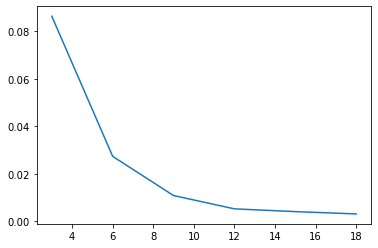

In [137]:
# Plot specific heat as function of temperature 

specific_heat = compute_specific_heat(samples)
plt.plot(J_over_kT, specific_heat)
plt.show()

In [ ]:
num_rows = 20
num_cols = 20
num_iterations = 10000
J_over_kT = np.arange(0, 20, 3)
samples = {}

for ii_temp in J_over_kT:

    print('Metropolis sampling temp: ', ii_temp)
    initial_lattice = create_random_lattice(num_rows, num_cols)
    samples[str(ii_temp)] = metropolis_sampling(initial_lattice, num_iterations, ii_temp)

magnetism = compute_magnetism(samples)
plt.plot(J_over_kT, magnetism)
plt.show()